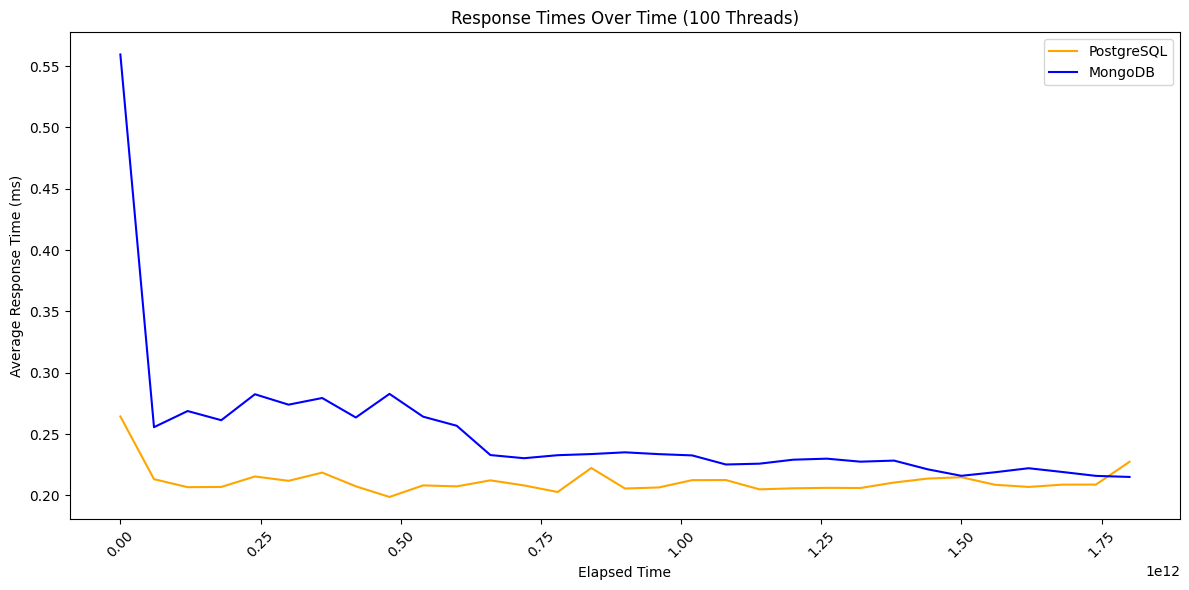

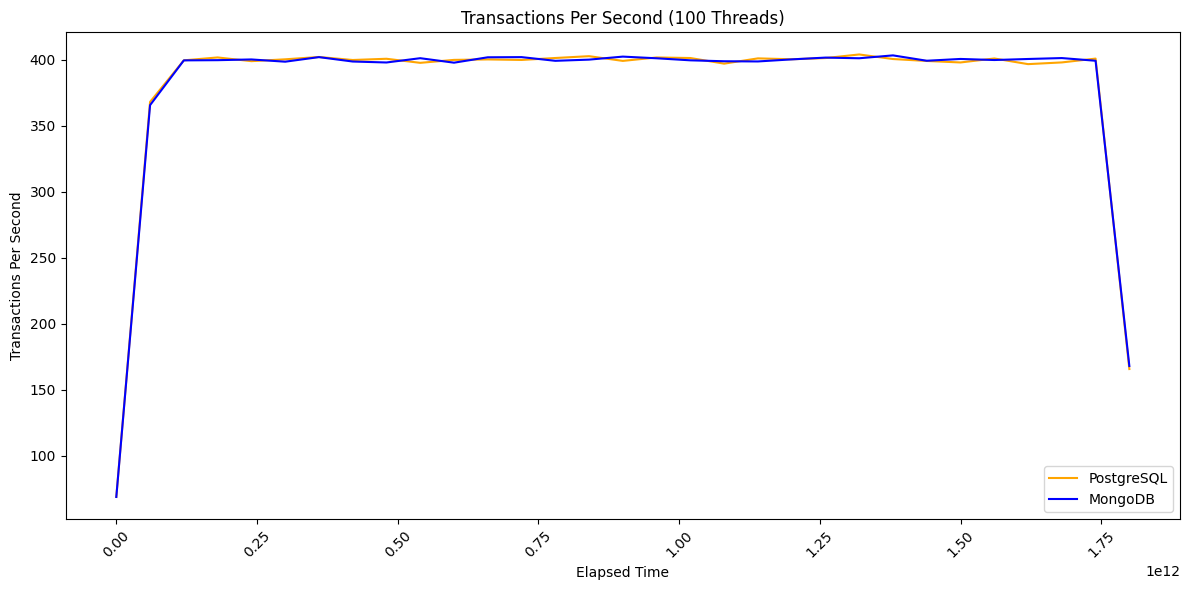

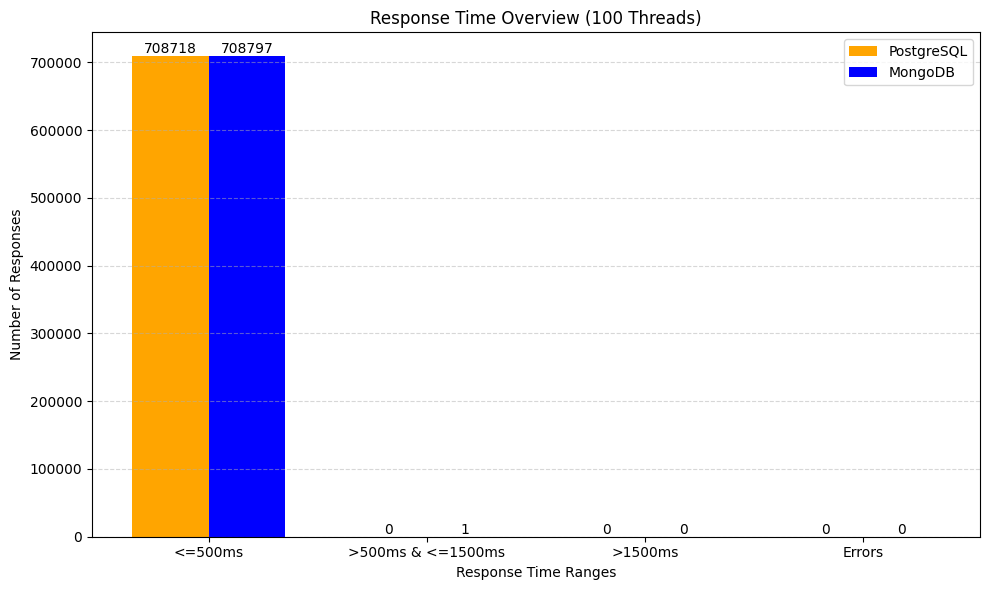

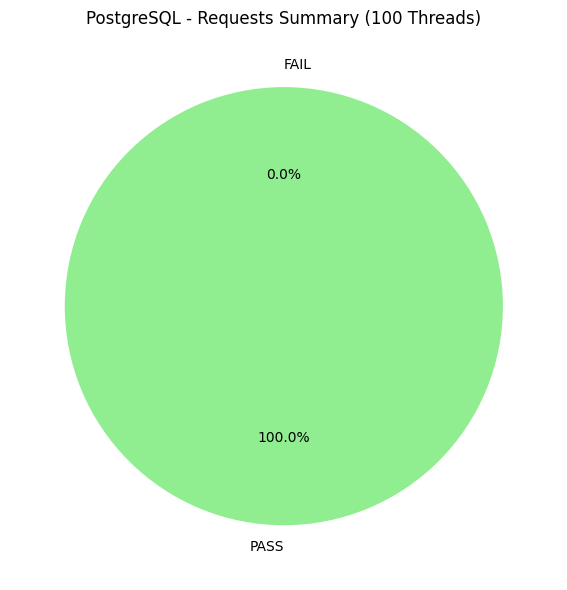

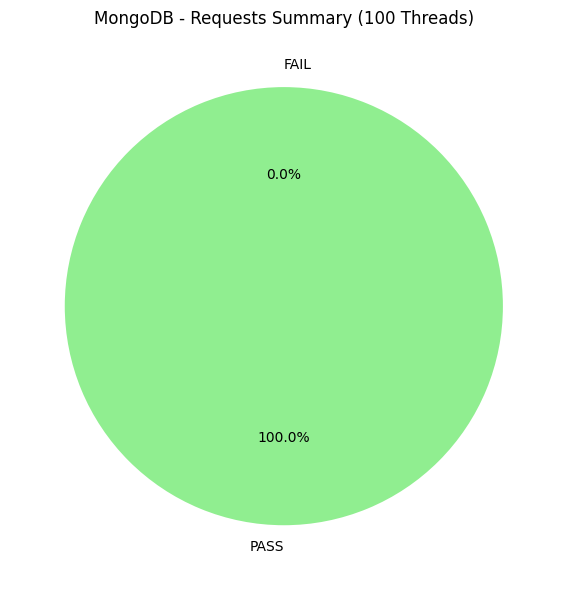

✅ All plots saved in 'plots/'


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# === PARAMS ===
db_pg = 'pg'
db_mongo = 'mongo'
ramp = '60'
threads = '100'
workload = 'insert'

input_pg_file = f'output/{db_pg}/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'
input_mongo_file = f'output/{db_mongo}/1800_seconds_duration/{ramp}_seconds_ramp/{threads}_threads/{workload}_workload/results.csv'

# === Output directory ===
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

# === Load data ===
df_pg = pd.read_csv(input_pg_file)
df_mongo = pd.read_csv(input_mongo_file)

# === Convert timestamp ===
df_pg['timeStamp'] = pd.to_datetime(df_pg['timeStamp'], unit='ms')
df_mongo['timeStamp'] = pd.to_datetime(df_mongo['timeStamp'], unit='ms')

df_pg['ElapsedTime'] = (df_pg['timeStamp'] - df_pg['timeStamp'].iloc[0]).dt.total_seconds()
df_mongo['ElapsedTime'] = (df_mongo['timeStamp'] - df_mongo['timeStamp'].iloc[0]).dt.total_seconds()

# === Resample ===
df_pg.set_index('timeStamp', inplace=True)
df_mongo.set_index('timeStamp', inplace=True)

response_pg = df_pg['elapsed'].resample('1T').mean()
response_mongo = df_mongo['elapsed'].resample('1T').mean()

tpm_pg = df_pg['elapsed'].resample('1T').count()
tpm_mongo = df_mongo['elapsed'].resample('1T').count()

tps_pg = tpm_pg / 60
tps_mongo = tpm_mongo / 60

# === Adjust time axis ===
response_pg.index = (response_pg.index - response_pg.index[0])
response_mongo.index = (response_mongo.index - response_mongo.index[0])
tps_pg.index = (tps_pg.index - tps_pg.index[0])
tps_mongo.index = (tps_mongo.index - tps_mongo.index[0])

# === Filenames helper ===
param_str = f"{ramp}_seconds_ramp_{threads}_threads_{workload}_workload"

# === Plot: Response Times Over Time ===
plt.figure(figsize=(12, 6))
plt.plot(response_pg.index, response_pg.values, label='PostgreSQL', color='orange')
plt.plot(response_mongo.index, response_mongo.values, label='MongoDB', color='blue')
plt.xlabel('Elapsed Time')
plt.ylabel('Average Response Time (ms)')
plt.title(f'Response Times Over Time ({threads} Threads)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

filename_response_time = f'{output_dir}/response_times_over_time_{param_str}.png'
plt.savefig(filename_response_time, dpi=300)
plt.show()

# === Plot: TPS ===
plt.figure(figsize=(12, 6))
plt.plot(tps_pg.index, tps_pg.values, label='PostgreSQL', color='orange')
plt.plot(tps_mongo.index, tps_mongo.values, label='MongoDB', color='blue')
plt.xlabel('Elapsed Time')
plt.ylabel('Transactions Per Second')
plt.title(f'Transactions Per Second ({threads} Threads)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

filename_tps = f'{output_dir}/transactions_per_second_{param_str}.png'
plt.savefig(filename_tps, dpi=300)
plt.show()

# === Response Time Overview ===
ranges = ['<=500ms', '>500ms & <=1500ms', '>1500ms', 'Errors']

def count_ranges(df):
    count_500 = len(df[df['elapsed'] <= 500])
    count_1500 = len(df[(df['elapsed'] > 500) & (df['elapsed'] <= 1500)])
    count_above = len(df[df['elapsed'] > 1500])
    count_errors = len(df[df['success'] == False]) if 'success' in df.columns else 0
    return [count_500, count_1500, count_above, count_errors]

counts_pg = count_ranges(df_pg)
counts_mongo = count_ranges(df_mongo)

x = np.arange(len(ranges))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
bars_pg = ax.bar(x - width/2, counts_pg, width, label='PostgreSQL', color='orange')
bars_mongo = ax.bar(x + width/2, counts_mongo, width, label='MongoDB', color='blue')

ax.set_xlabel('Response Time Ranges')
ax.set_ylabel('Number of Responses')
ax.set_title(f'Response Time Overview ({threads} Threads)')
ax.set_xticks(x)
ax.set_xticklabels(ranges)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

for bars in [bars_pg, bars_mongo]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom')

plt.tight_layout()

filename_overview = f'{output_dir}/response_time_overview_{param_str}.png'
plt.savefig(filename_overview, dpi=300)
plt.show()

# === Requests Summary Pie Chart ===
def count_pass_fail(df):
    if 'success' in df.columns:
        pass_count = df['success'].sum()
        fail_count = len(df) - pass_count
    else:
        pass_count = len(df[df['responseCode'] == 200])
        fail_count = len(df) - pass_count
    return pass_count, fail_count

pg_pass, pg_fail = count_pass_fail(df_pg)
mongo_pass, mongo_fail = count_pass_fail(df_mongo)

# PostgreSQL pie
plt.figure(figsize=(6,6))
plt.pie([pg_pass, pg_fail], labels=['PASS', 'FAIL'], colors=['lightgreen', 'red'],
        autopct='%1.1f%%', startangle=90)
plt.title(f'PostgreSQL - Requests Summary ({threads} Threads)')
plt.tight_layout()

filename_pg_pie = f'{output_dir}/requests_summary_pg_{param_str}.png'
plt.savefig(filename_pg_pie, dpi=300)
plt.show()

# MongoDB pie
plt.figure(figsize=(6,6))
plt.pie([mongo_pass, mongo_fail], labels=['PASS', 'FAIL'], colors=['lightgreen', 'red'],
        autopct='%1.1f%%', startangle=90)
plt.title(f'MongoDB - Requests Summary ({threads} Threads)')
plt.tight_layout()

filename_mongo_pie = f'{output_dir}/requests_summary_mongo_{param_str}.png'
plt.savefig(filename_mongo_pie, dpi=300)
plt.show()

print(f"✅ All plots saved in '{output_dir}/'")
